<a href="https://colab.research.google.com/github/ronen-halevy/ai-notebooks/blob/main/notebooks/create_tfrecords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Create Tfrecords

This post present the create-tfrecords repository, with a use case example.

The repository consists of 2 scripts:
1. Creates a image classificatoin and detection tfrecord dataset.
2. Reads the tfrecord dataset and renders example images with the bounding boxes annotation data.

Here below, create tfrecord operation is illustrated using `shapes` dataset. Create Tfrecord takes `shapes` images and metadata as input and produces tfrecords files.


Let's clone the `shapes` repository so we can use the dataset input.

In [ ]:
!git clone https://github.com/ronen-halevy/shapes-dataset.git

Cloning into 'shapes-dataset'...
remote: Enumerating objects: 140483, done.
remote: Counting objects: 100% (40030/40030), done.
remote: Compressing objects: 100% (39793/39793), done.
remote: Total 140483 (delta 246), reused 40019 (delta 235), pack-reused 100453
Receiving objects: 100% (140483/140483), 861.74 MiB | 27.45 MiB/s, done.
Resolving deltas: 100% (1507/1507), done.
Checking out files: 100% (10012/10012), done.


## 1. Create tfrecord dataset

In [ ]:
import os
import glob
import json
import tensorflow as tf
import numpy as np
import argparse


class ExampleProtos:
    @staticmethod
    def image_feature(value):
        return tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
        )

    @staticmethod
    def bytes_feature(value):
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))

    @staticmethod
    def bytes_feature_list(value):
        value = [x.encode('utf8') for x in value]
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

    @staticmethod
    def float_feature(value):
        return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

    @staticmethod
    def int64_feature(value):
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

    @staticmethod
    def int64_feature_list(value):
        return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

    @staticmethod
    def float_feature_list(value):
        return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def create_example(image, example):
    boxes = np.reshape(example['bboxes'], -1)
    label = [entry['label'] for entry in example['objects']]

    feature = {
        'image/encoded': ExampleProtos.image_feature(image),
        'image/object/bbox/xmin': ExampleProtos.float_feature_list(boxes[0::4].tolist()),
        'image/object/bbox/ymin': ExampleProtos.float_feature_list(boxes[1::4].tolist()),
        'image/object/bbox/xmax': ExampleProtos.float_feature_list(boxes[2::4].tolist()),
        'image/object/bbox/ymax': ExampleProtos.float_feature_list(boxes[3::4].tolist()),
        'image/object/class/label': ExampleProtos.bytes_feature_list(label),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


def create_tfrecords(input_annotation_file, images_dir, tfrecords_out_dir, tfrec_file_size, examples_limit=None):
    with open(input_annotation_file, 'r') as f:
        annotations = json.load(f)['annotations']

    num_examples = min(len(annotations), examples_limit or float('inf'))
    num_samples_in_tfrecord = min(tfrec_file_size, num_examples)
    num_tfrecords = num_examples // num_samples_in_tfrecord
    if num_examples % num_samples_in_tfrecord:
        num_tfrecords += 1

    if not os.path.exists(tfrecords_out_dir):
        os.makedirs(tfrecords_out_dir)
    else:
        to_del_files = glob.glob(f'{tfrecords_out_dir}/*.tfrec')
        [os.remove(f) for f in to_del_files]

    print(f'Starting! \nCreating {num_examples} examples in {num_tfrecords} tfrecord files.')
    print(f'Output dir: {tfrecords_out_dir}')

    for tfrec_num in range(num_tfrecords):
        samples = annotations[(tfrec_num * num_samples_in_tfrecord): ((tfrec_num + 1) * num_samples_in_tfrecord)]

        with tf.io.TFRecordWriter(
                tfrecords_out_dir + '/file_%.2i-%i.tfrec' % (tfrec_num, len(samples))
        ) as writer:
            for sample in samples:
                image_path = images_dir + sample['image_filename']
                image = tf.io.decode_jpeg(tf.io.read_file(image_path))
                example = create_example(image, sample)
                writer.write(example.SerializeToString())

    print('Done!')


In [ ]:
annotations = '/content/shapes-dataset/dataset/annotations/annotations.json'
out_dir = './dataset/tfrecords'
images_dir = '/content/shapes-dataset/dataset/images/'
tfrec_file_size = 4096
examples_limit = None
create_tfrecords(annotations, images_dir, out_dir, tfrec_file_size, examples_limit)

Starting! 
Creating 10000 examples in 3 tfrecord files.
Output dir: ./dataset/tfrecords
Done!


## 2. Read Examples from Tfrecords Files

The data is extracted from files and parsed

In [ ]:
import tensorflow as tf

def parse_tfrecord_fn(tfrecord, class_table, max_boxes, size):
    feature_description = {
        "image/encoded": tf.io.FixedLenFeature([], tf.string),
        "image/object/class/label": tf.io.VarLenFeature(tf.string),
        "image/object/bbox/xmin": tf.io.VarLenFeature(tf.float32),
        "image/object/bbox/ymin": tf.io.VarLenFeature(tf.float32),
        "image/object/bbox/xmax": tf.io.VarLenFeature(tf.float32),
        "image/object/bbox/ymax": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(tfrecord, feature_description)

    x_train = tf.image.decode_jpeg(example['image/encoded'], channels=3)
    x_train = tf.image.resize(x_train, (size, size)) / 255

    labels = tf.sparse.to_dense(
        example.get('image/object/class/label', ','), default_value='')
    labels = tf.cast(class_table.lookup(labels), tf.float32)
    y_train = tf.stack([tf.sparse.to_dense(example['image/object/bbox/xmin']),
                        tf.sparse.to_dense(example['image/object/bbox/ymin']),
                        tf.sparse.to_dense(example['image/object/bbox/xmax']),
                        tf.sparse.to_dense(example['image/object/bbox/ymax']),
                        labels], axis=1)

    paddings = [[0, max_boxes - tf.shape(y_train)[0]], [0, 0]]
    y_train = tf.pad(y_train, paddings)

    return x_train, y_train

 

In [ ]:
def read_dataset(class_file, tfrecords_dir, max_boxes):
    class_table = tf.lookup.StaticHashTable(tf.lookup.TextFileInitializer(
        filename=class_file, key_dtype=tf.string, key_index=0, value_dtype=tf.int64,
        value_index=tf.lookup.TextFileIndex.LINE_NUMBER, delimiter="\n"), default_value=-1)

    files = tf.data.Dataset.list_files(f"{tfrecords_dir}/*.tfrec")

    dataset = files.flat_map(tf.data.TFRecordDataset)
    dataset = dataset.map(lambda tfrecord: parse_tfrecord_fn(tfrecord, class_table, max_boxes, size=416))
    return dataset

In [ ]:
tfrecords_dir = './dataset/tfrecords'

class_file = '/content/shapes-dataset/dataset/class.names'
max_boxes = 100
dataset = read_dataset(class_file, tfrecords_dir, max_boxes)


## 3. Illustrate Plotting Dataset Examples

Using the parsed dataset, drow some example images with bounding boxes and text labels overlayed.

In [ ]:
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont

def draw_text_on_bounding_box(image, ymin, xmin, color, display_str_list=(), font_size=30):
    draw = ImageDraw.Draw(image)
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                                  font_size)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    text_margin_factor = 0.05

    text_widths, text_heights = zip(*[font.getsize(display_str) for display_str in display_str_list])
    text_margins = np.ceil(text_margin_factor * np.array(text_heights))
    text_bottoms = ymin * (ymin > text_heights) + (ymin + text_heights) * (ymin <= text_heights)

    for idx, (display_str, xmint, text_bottom, text_width, text_height, text_margin) in enumerate(
            zip(display_str_list, xmin, text_bottoms, text_widths, text_heights, text_margins)):
        text_width, text_height = font.getsize(display_str)
        text_margin = np.ceil(text_margin_factor * text_height)

        draw.rectangle(((xmint, text_bottom - text_height - 2 * text_margin),
                        (xmint + text_width + text_margin, text_bottom)),
                       fill=color)

        draw.text((xmint + text_margin, text_bottom - text_height - text_margin),
                  display_str,
                  fill="black",
                  font=font)
    return image


In [ ]:
def draw_bounding_box(image, boxes, color, thickness=3):
    draw = ImageDraw.Draw(image)
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        draw.line([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin),
                   (xmin, ymin)],
                  width=thickness,
                  fill=color)
    return image


In [ ]:
def render_dataset_examples(dataset, class_file):
    data = dataset.take(1)
    image, y = next(iter(data))

    y = y[y[..., 2].numpy() != 0]  # remove padding
    image_pil = Image.fromarray(np.uint8(image.numpy() * 255))
    annotated_bbox_image = draw_bounding_box(image_pil, y[..., 0:4], color=(255, 255, 0),
                                             thickness=3)

    colors = list(ImageColor.colormap.values())
    color = colors[0]
    class_text = np.loadtxt(class_file, dtype=str)

    classes = class_text[y[..., 4].numpy().astype(int)]
    annotated_text_image = draw_text_on_bounding_box(annotated_bbox_image, y[..., 1].numpy(), y[..., 0].numpy(), color,
                                                     classes, font_size=15)
    return annotated_text_image

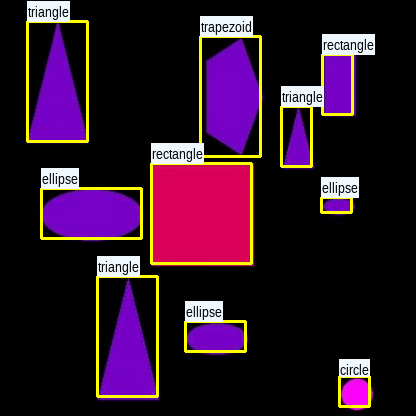

In [ ]:
render_dataset_examples(dataset, class_file)


## 4. Illustrate dataset split to Train, Validation and Test splits

In [ ]:
ds_size = sum(1 for _ in dataset)
train_split = 0.7
val_split = 0.20
test_split = 0.10

In [ ]:
train_size = int(train_split * ds_size)
val_size = int(val_split * ds_size)
test_size = int(test_split * ds_size)
# for a perfect shuffle buffer size should equal the dataset size. Otherwise, 
# take care to shuffle when creating tfrecords
full_dataset = dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=False)
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
val_dataset = dataset.skip(train_size+test_size)
test_dataset = test_dataset.take(test_size)